## 드라이브에서 파일 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/\(데이콘\)운동동작분류/data ./

## 모듈불러오기

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, MaxPool1D, SeparableConv1D, AvgPool1D, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Flatten, Activation, Dropout, BatchNormalization, Input, Add, GlobalAvgPool1D, Subtract, Reshape, Concatenate, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## train X 처리

In [ ]:
df = pd.read_csv('./data/train_features.csv')
train_x = df.values[:,2:].reshape(-1,600,6)
print(train_x.shape)
# df

NameError: ignored

## train Y 처리

In [ ]:
df = pd.read_csv('./data/train_labels.csv')
train_y = df.values[:,1].astype(np.int)
print(train_y.shape)
df

(3125,)


,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [ ]:
def show_data(x, label):
  print(label)
  data = x
  fig = plt.figure(figsize=(14,5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)
  ax1.plot(data[:,0], label='acc_x')
  ax1.plot(data[:,1], label='acc_y')
  ax1.plot(data[:,2], label='acc_z')
  ax1.grid()
  ax1.legend()
  ax2.plot(data[:,3], label='gy_x')
  ax2.plot(data[:,4], label='gy_y')
  ax2.plot(data[:,5], label='gy_z')
  ax2.grid()
  ax2.legend()

  plt.show()

In [ ]:
# new_train_x = np.concatenate([train_x[:, 200:, :], train_x[:, :200, :]], axis=1)
# new_train_x.shape

In [ ]:
# show_data(train_x[0], train_y[0])

In [ ]:
# show_data(new_train_x[0], train_y[0])

In [ ]:
np.where(train_y==15)[0][:10]

array([  29,  101,  397,  537,  587,  738,  795,  891,  974, 1168])

In [ ]:
np.where(train_y==8)[0]

array([  41,   85,   88,  159,  191,  276,  294,  305,  334,  400,  414,
        453,  506,  559,  579,  607,  618,  653,  690,  695,  720,  824,
        847,  883,  903,  916,  949, 1027, 1049, 1051, 1093, 1096, 1147,
       1170, 1188, 1224, 1237, 1318, 1354, 1385, 1408, 1434, 1442, 1449,
       1457, 1506, 1614, 1653, 1657, 1743, 1775, 1793, 1895, 1911, 1953,
       1954, 1958, 2029, 2036, 2048, 2053, 2065, 2072, 2083, 2094, 2135,
       2149, 2159, 2236, 2243, 2310, 2361, 2418, 2420, 2449, 2484, 2490,
       2493, 2568, 2620, 2652, 2667, 2669, 2671, 2748, 2754, 2766, 2775,
       2778, 2838, 2960, 2989, 2996, 3049, 3054, 3064, 3103])

0


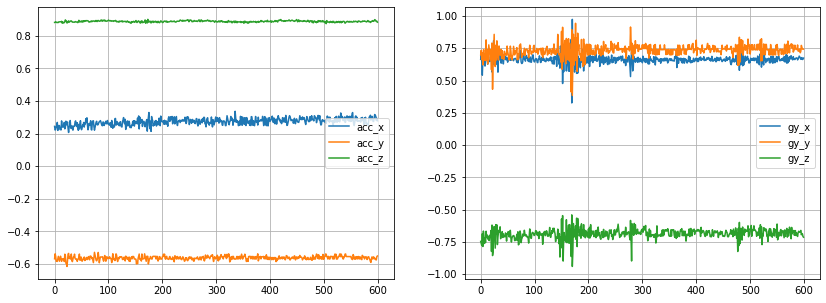

In [ ]:
show_data(train_x[1049], 0)

0


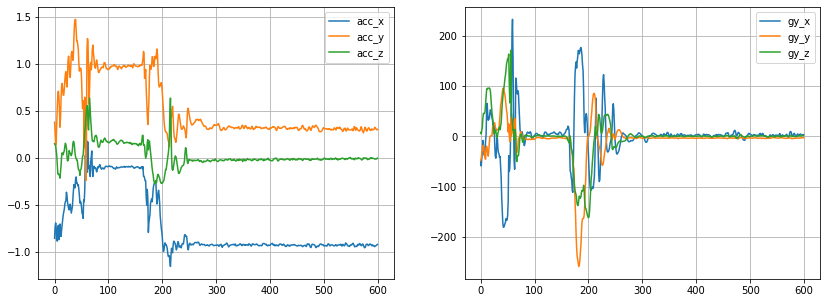

In [ ]:
show_data(train_x[2211], 0)

In [ ]:
df.values[1515,2]

'Arm Band Adjustment'

In [ ]:
sorted(np.unique(list(zip((df.values[:,1]), df.values[:,2])), axis=0), key=lambda x:int(x[0]))

In [ ]:
# data normalization

epsilon = 0.1

avg = np.mean(train_x, axis=1).reshape(-1, 1, 6)
train_x -= avg
# _max = np.max(np.abs(train_x), axis=1).reshape(-1, 1, 6) + epsilon
# train_x /= _max
train_x.shape

(3125, 600, 6)

In [ ]:
bb = train_x - aa.reshape(-1, 1, 6)
bb.shape

(3125, 600, 6)

In [ ]:
np.max(np.abs(train_x), axis=1).reshape(-1, 1, 6)

(3125, 6)

## learning rate 스케줄 함수

In [ ]:
def lr_scheduler(epoch, lr):
  if epoch < 10 or epoch > 60:
    return lr
  else:
    return lr * 0.95

callback1 = LearningRateScheduler(lr_scheduler)

## 모델 생성

In [ ]:
def conv1d_bn(x, filters, kernel_size, padding='same', strides=1, activation='elu', weight_decay=1e-5, bn = True):
    x = Conv1D(filters, kernel_size, padding=padding, strides=strides, kernel_regularizer=l2(weight_decay))(x)
    if bn: x = BatchNormalization()(x)
    if activation: x = Activation(activation)(x)
    return x

def sepconv1d_bn(x, filters, kernel_size, padding='same', strides=1, activation='elu', weight_decay=1e-5, depth_multiplier=1, bn = True):
    x = SeparableConv1D(filters, kernel_size, padding=padding, strides=strides, depth_multiplier=depth_multiplier, depthwise_regularizer=l2(weight_decay), pointwise_regularizer=l2(weight_decay))(x)
    if bn: x = BatchNormalization()(x)
    if activation: x = Activation(activation)(x)
    return x

In [ ]:
def Xception(model_input, classes):
    ## Entry flow
    x = conv1d_bn(model_input, 32, 3, strides=2) # (600, 6) -> (300, 32)
    x = conv1d_bn(x, 64, 3)

    for filters in [128, 256, 728]: # (300, 64) -> (150, 128) -> (75, 256) -> (38, 728)
        residual = conv1d_bn(x, filters, 1, strides=2, activation=None)

        if filters != 128:
          x = Activation(activation='relu')(x)
        x = sepconv1d_bn(x, filters, 3)
        x = sepconv1d_bn(x, filters, 3, activation=None)
        x = MaxPool1D(3, padding='same', strides=2)(x)
        
        x = Add()([x, residual])
    # x = Dropout(0.15)(x) ###############
        
    ## Middle flow
    for i in range(8): # (38, 728)
        residual = x
        
        x = Activation(activation='relu')(x)
        x = sepconv1d_bn(x, 728, 3)
        x = sepconv1d_bn(x, 728, 3)
        x = sepconv1d_bn(x, 728, 3, activation=None)
        
        x = Add()([x, residual])
    # x = Dropout(0.15)(x) ###############
        
    ## Exit flow
    residual = conv1d_bn(x, 1024, 1, strides=2, activation=None) # (38, 728) -> (19, 1024)
        
    x = Activation(activation='relu')(x)
    x = sepconv1d_bn(x, 728, 3)
    x = sepconv1d_bn(x, 1024, 3, activation=None) # (38, 728) -> (38, 1024)
    x = MaxPool1D(3, padding='same', strides=2)(x) # (38, 1024) -> (19, 1024)
    
    x = Add()([x, residual])
    
    x = sepconv1d_bn(x, 1536, 3)
    x = sepconv1d_bn(x, 2048, 3)

    x = GlobalAvgPool1D()(x)
    
    ## Optinal fully-connected layers
    '''
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    '''
    
    # x = Dropout(0.5)(x)
    
    model_output = Dense(classes, activation='softmax')(x)

    model = Model(model_input, model_output, name='Xception')
    
    return model


input_shape = (600,6)
classes = 61

model_input = Input( shape=input_shape )

model = Xception(model_input, classes)

optimizer = SGD(lr=0.001, momentum=0.9)
# optimizer = Adam(lr=0.045)

# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])

model.summary()

In [ ]:
# keep # 0.6402 # epoch 70 # batchsize 12 # lr_decay 0.95
model_input = Input(shape=(600,6))
x = model_input

res = conv1d_bn(x, 64, 1, strides=2, activation=None)
x = conv1d_bn(x, 64, 3, activation='elu')
x = conv1d_bn(x, 64, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 128, 1, strides=2, activation=None)
x = conv1d_bn(x, 128, 3, activation='elu')
x = conv1d_bn(x, 128, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 256, 1, strides=2, activation=None)
x = conv1d_bn(x, 256, 3, activation='elu')
x = conv1d_bn(x, 256, 3, activation='elu')
x = conv1d_bn(x, 256, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 512, 1, strides=2, activation=None)
x = conv1d_bn(x, 512, 3, activation='elu')
x = conv1d_bn(x, 512, 3, activation='elu')
x = conv1d_bn(x, 512, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

x = GlobalAvgPool1D()(x)

model_output = Dense(61, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
model.summary()

In [ ]:
model_input = Input(shape=(600,6))
x = model_input

# x = tf.keras.layers.Lambda(lambda x: x[:,:,3:])(x)

# x = AvgPool1D(pool_size=2, strides=2, padding='same')(x)
# x = AvgPool1D(pool_size=2, strides=2, padding='same')(x)
# x = conv1d_bn(x, 16, 3)
# x = conv1d_bn(x, 32, 3)

for filters in [64, 128, 256, 512]:
  residual = conv1d_bn(x, filters, 1, strides=2, activation=None)

  if filters != 64:
    x = Activation(activation='relu')(x)
  x = sepconv1d_bn(x, filters, 3)
  x = sepconv1d_bn(x, filters, 3, activation=None)
  x = MaxPool1D(3, padding='same', strides=2)(x)
  
  x = Add()([x, residual])

# res = conv1d_bn(x, 64, 1, strides=2, activation=None)
# x = sepconv1d_bn(x, 64, 3)
# x = sepconv1d_bn(x, 64, 3, activation=None)
# x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
# x = Add()([x, res])
# x = Activation('elu')(x)

# res = conv1d_bn(x, 128, 1, strides=2, activation=None)
# x = sepconv1d_bn(x, 128, 3)
# x = sepconv1d_bn(x, 128, 3, activation=None)
# x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
# x = Add()([x, res])
# x = Activation('elu')(x)

# res = conv1d_bn(x, 256, 1, strides=2, activation=None)
# x = sepconv1d_bn(x, 256, 3)
# x = sepconv1d_bn(x, 256, 3)
# x = sepconv1d_bn(x, 256, 3, activation=None)
# x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
# x = Add()([x, res])
# x = Activation('elu')(x)

# res = conv1d_bn(x, 512, 1, strides=2, activation=None)
# x = sepconv1d_bn(x, 512, 3)
# x = sepconv1d_bn(x, 512, 3)
# x = sepconv1d_bn(x, 512, 3, activation=None)
# x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
# x = Add()([x, res])
# x = Activation('elu')(x)

# for i in range(4):
#   res = x
#   x = Activation(activation='elu')(x)
#   x = sepconv1d_bn(x, 512, 3)
#   x = sepconv1d_bn(x, 512, 3)
#   x = sepconv1d_bn(x, 512, 3, activation=None)
#   x = Add()([x, res])

x = Activation('elu')(x)

x = GlobalAvgPool1D()(x)
# x = Flatten()(x)
# x = Dense(4096 ,activation="relu")(x)
model_output = Dense(61, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
model_input = Input(shape=(600,6))
x = model_input

# x = conv1d_bn(x, 32, 3, padding='valid')
# x = conv1d_bn(x, 32, 3)

for filters in [64, 128, 256, 512]:
  residual = conv1d_bn(x, filters, 1, strides=2, activation=None)

  if filters != 64:
    x = Activation(activation='elu')(x)
  x = sepconv1d_bn(x, filters, 3, activation='elu')
  x = sepconv1d_bn(x, filters, 3, activation=None)
  x = MaxPool1D(3, padding='same', strides=2)(x)
  
  x = Add()([x, residual])


x = Activation('elu')(x)

x = GlobalAvgPool1D()(x)
# x = Flatten()(x)
# x = Dense(4096 ,activation="relu")(x)
model_output = Dense(61, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
model.summary()

In [ ]:
# keep
model_input = Input(shape=(600,6))
x = model_input

# x = conv1d_bn(x, 32, 3, padding='valid')
# x = conv1d_bn(x, 32, 3)

for filters in [64, 128, 256, 512]:
  residual = conv1d_bn(x, filters, 1, strides=2, activation=None)#, bn=False)

  if filters != 64:
    # x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    pass
  x = sepconv1d_bn(x, filters, 3, activation='relu')
  x = sepconv1d_bn(x, filters, 3, activation=None)#, bn=False)
  x = MaxPool1D(3, padding='same', strides=2)(x)
  
  x = Add()([x, residual])

x = BatchNormalization()(x)
# x = Activation('relu')(x)

x = GlobalAvgPool1D()(x)
# x = Flatten()(x)
# x = Dense(4096 ,activation="relu")(x)
# x = Dropout(0.5)(x)
model_output = Dense(61, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
# model.summary()

In [ ]:
# keep
model_input = Input(shape=(600,6))
x = model_input

# x = conv1d_bn(x, 32, 3, padding='valid')
# x = conv1d_bn(x, 32, 3)

for filters in [64, 128, 256, 512]:
  residual = conv1d_bn(x, filters, 1, strides=2, activation=None)#, bn=False)

  if filters != 64:
    # x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    pass
  x = sepconv1d_bn(x, filters, 3, activation='relu')
  x = sepconv1d_bn(x, filters, 3, activation=None)#, bn=False)
  x = MaxPool1D(3, padding='same', strides=2)(x)
  
  x = Add()([x, residual])

x = BatchNormalization()(x)
# x = Activation('relu')(x)

x = GlobalAvgPool1D()(x)
# x = Flatten()(x)
# x = Dense(4096 ,activation="relu")(x)
# x = Dropout(0.5)(x)
model_output = Dense(61, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])
# model.summary()

In [ ]:
model_input = Input(shape=(600,6))
x = model_input

x = conv1d_bn(x, 64, 7, strides=2, activation=None, bn=False)
# x = conv1d_bn(x, 32, 3)

filters = 64
for i in range(3):
  residual = Dropout(0.25)(x)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  x = conv1d_bn(x, filters, 3, activation='relu')
  x = conv1d_bn(x, filters, 3, activation=None, bn=False)
  x = Add()([x, residual])

filters = 128
x = BatchNormalization()(x)
x = Activation(activation='relu')(x)
x = conv1d_bn(x, filters, 3, activation='relu', strides=2)
x = conv1d_bn(x, filters, 3, activation=None, bn=False)
for i in range(3):
  residual = Dropout(0.25)(x)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  x = conv1d_bn(x, filters, 3, activation='relu')
  x = conv1d_bn(x, filters, 3, activation=None, bn=False)
  x = Add()([x, residual])

filters = 256
x = BatchNormalization()(x)
x = Activation(activation='relu')(x)
x = conv1d_bn(x, filters, 3, activation='relu', strides=2)
x = conv1d_bn(x, filters, 3, activation=None, bn=False)
for i in range(5):
  residual = Dropout(0.25)(x)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  x = conv1d_bn(x, filters, 3, activation='relu')
  x = conv1d_bn(x, filters, 3, activation=None, bn=False)
  x = Add()([x, residual])

filters = 512
x = BatchNormalization()(x)
x = Activation(activation='relu')(x)
x = conv1d_bn(x, filters, 3, activation='relu', strides=2)
x = conv1d_bn(x, filters, 3, activation=None, bn=False)
for i in range(2):
  residual = Dropout(0.25)(x)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  x = conv1d_bn(x, filters, 3, activation='relu')
  x = conv1d_bn(x, filters, 3, activation=None, bn=False)
  x = Add()([x, residual])



# x = Activation('elu')(x)

x = GlobalAvgPool1D()(x)
# x = Flatten()(x)
# x = Dense(4096 ,activation="relu")(x)
x = Dropout(0.5)(x)
model_output = Dense(61, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
model.summary()

In [ ]:
############
model_input = Input(shape=(600,6))
x = model_input

res = conv1d_bn(x, 64, 1, strides=2, activation=None)
x = conv1d_bn(x, 64, 3, activation='relu')
x = conv1d_bn(x, 64, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('relu')(x)

out1 = GlobalAvgPool1D()(x)
out1 = Dense(61, activation="softmax", name='out1')(out1)

res = conv1d_bn(x, 128, 1, strides=2, activation=None)
x = conv1d_bn(x, 128, 3, activation='relu')
x = conv1d_bn(x, 128, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('relu')(x)

out2 = GlobalAvgPool1D()(x)
out2 = Dense(61, activation="softmax", name='out2')(out2)

res = conv1d_bn(x, 256, 1, strides=2, activation=None)
x = conv1d_bn(x, 256, 3, activation='relu')
x = conv1d_bn(x, 256, 3, activation='relu')
x = conv1d_bn(x, 256, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('relu')(x)

out3 = GlobalAvgPool1D()(x)
out3 = Dense(61, activation="softmax", name='out3')(out3)

res = conv1d_bn(x, 512, 1, strides=2, activation=None)
x = conv1d_bn(x, 512, 3, activation='relu')
x = conv1d_bn(x, 512, 3, activation='relu')
x = conv1d_bn(x, 512, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('relu')(x)

out4 = GlobalAvgPool1D()(x)
out4 = Dense(61, activation="softmax", name='out4')(out4)


model = Model(model_input, outputs=[out1, out2, out3, out4])
# model = Model(model_input, outputs=[out2, out4])

optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer, loss=['sparse_categorical_crossentropy']*4, metrics=['acc'])
# model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
model.summary()

In [ ]:
# keep # 0.53753 # epoch 60 # batchsize 12 # lr_decay 0.95 # acc_std, gy_std
model_input = Input(shape=(600,8))
x = model_input

res = conv1d_bn(x, 64, 1, strides=2, activation=None)
x = conv1d_bn(x, 64, 3, activation='elu')
x = conv1d_bn(x, 64, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 128, 1, strides=2, activation=None)
x = conv1d_bn(x, 128, 3, activation='elu')
x = conv1d_bn(x, 128, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 256, 1, strides=2, activation=None)
x = conv1d_bn(x, 256, 3, activation='elu')
x = conv1d_bn(x, 256, 3, activation='elu')
x = conv1d_bn(x, 256, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 512, 1, strides=2, activation=None)
x = conv1d_bn(x, 512, 3, activation='elu')
x = conv1d_bn(x, 512, 3, activation='elu')
x = conv1d_bn(x, 512, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

x = GlobalAvgPool1D()(x)

model_output = Dense(61, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
# model.summary()

In [ ]:
model_input = Input(shape=(600,8))
x = model_input

res = conv1d_bn(x, 64, 1, strides=2, activation=None)
x = conv1d_bn(x, 64, 3, activation='elu')
x = conv1d_bn(x, 64, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 128, 1, strides=2, activation=None)
x = conv1d_bn(x, 128, 3, activation='elu')
x = conv1d_bn(x, 128, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 256, 1, strides=2, activation=None)
x = conv1d_bn(x, 256, 3, activation='elu')
x = conv1d_bn(x, 256, 3, activation='elu')
x = conv1d_bn(x, 256, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 512, 1, strides=2, activation=None)
x = conv1d_bn(x, 512, 3, activation='elu')
x = conv1d_bn(x, 512, 3, activation='elu')
x = conv1d_bn(x, 512, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

x = GlobalAvgPool1D()(x)

model_output = Dense(61, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
# model.summary()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 600, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 600, 64)      1600        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 600, 64)      256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 600, 64)      0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [ ]:
def focal_loss(y_true, y_pred):
  # gamma = 2.0
  # alpha = 0.25
  gamma = 2
  alpha = 0.25
  pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
  pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
  return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))



## 모델 학습

In [ ]:
def noise(train):
  noi = 1 + np.random.randn(*train.shape)/30
  return train * noi


In [ ]:
df = pd.read_csv('./data/train_features.csv')
# df
train_x = df.values[:,2:].reshape(-1,600,6)
train_x.shape

(3125, 600, 6)

In [ ]:
train_x[:,:,3:] /= 100

acc_std = np.std(train_x[:,:,:3], axis=-1).reshape(-1, 600, 1)
gy_std = np.std(train_x[:,:,3:], axis=-1).reshape(-1, 600, 1)

# acc_mean = np.mean(train_x[:,:,:3], axis=-1).reshape(-1, 600, 1)
# gy_mean = np.mean(train_x[:,:,3:], axis=-1).reshape(-1, 600, 1)

# acc_norm = np.linalg.norm(train_x[:,:,:3], axis=-1).reshape(-1, 600, 1)
# gy_norm = np.linalg.norm(train_x[:,:,3:], axis=-1).reshape(-1, 600, 1)

# std = np.std(train_x[:,:,:], axis=-1).reshape(-1, 600, 1)

train_x = np.concatenate([train_x, acc_std, gy_std], axis=-1)
# train_x = np.concatenate([train_x, acc_std, gy_std, acc_mean, gy_mean, acc_norm, gy_norm], axis=-1)
train_x.shape


(3125, 600, 8)

In [ ]:
from sklearn.model_selection import train_test_split

part_x, valid_x, part_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=666)
# part_x, valid_x, part_y, valid_y = train_test_split(new_train_x, train_y, test_size=0.1, random_state=666)
  
# new_train_x = np.concatenate([noise(part_x), noise(part_x), noise(part_x)])
# new_train_y = np.concatenate([part_y, part_y, part_y])
# print(new_train_x.shape)
# print(new_train_y.shape)
print(part_x.shape)
print(part_y.shape)
print(valid_x.shape)
print(valid_y.shape)


(2812, 600, 8)
(2812,)
(313, 600, 8)
(313,)


## Data Augmentation

In [ ]:
def data_aug(one_data): # (600, 6)
  n = 5
  aug_data = one_data[np.newaxis, :, :].tolist()
  one_data = one_data.tolist()

  for i in range(n-1):
    # r = np.random.randint(50,550)
    # one = one_data[r:] + one_data[:r]
    one = one_data[(i+1)*600//n:] + one_data[:(i+1)*600//n]
    aug_data.append(copy.deepcopy(one))

  return aug_data # (10, 600, 6) # list

In [ ]:
# augmentation

aug_train_x = data_aug(part_x[0, :, :])

for one_data in tqdm(part_x[1:]):
  one_data = data_aug(one_data)
  aug_train_x.extend(one_data)

aug_train_x = np.array(aug_train_x)
print(aug_train_x.shape)

aug_train_y = []
for _ in range(10):
  aug_train_y.append(part_y.tolist())

aug_train_y = np.array(aug_train_y).T.flatten()

print(aug_train_y.shape)

In [ ]:
# 26 제외 augmentation

aug_train_x = []
aug_train_y = []

for one_data, one_label in tqdm(zip(part_x, part_y)):
  if one_label == 26:
    aug_train_x.extend(one_data.reshape(1,600,-1).tolist())
    aug_train_y.append(one_label)
    continue

  one_data = data_aug(one_data)
  aug_train_x.extend(one_data)
  aug_train_y.extend([one_label]*5)

aug_train_x = np.array(aug_train_x)
aug_train_y = np.array(aug_train_y)
print(aug_train_x.shape)
print(aug_train_y.shape)

2812it [00:31, 89.94it/s]

(8572, 600, 12)
(8572,)


In [ ]:
# all
# 26 제외 augmentation

aug_train_x = []
aug_train_y = []

for one_data, one_label in tqdm(zip(train_x, train_y)):
  if one_label == 26:
    aug_train_x.extend(one_data.reshape(1,600,6).tolist())
    aug_train_y.append(one_label)
    continue

  one_data = data_aug(one_data)
  aug_train_x.extend(one_data)
  aug_train_y.extend([one_label]*5)

aug_train_x = np.array(aug_train_x)
aug_train_y = np.array(aug_train_y)
print(aug_train_x.shape)
print(aug_train_y.shape)

3125it [00:20, 149.15it/s]


(9553, 600, 6)
(9553,)


In [ ]:
# 압축
def data_press(one_data): # (600,6) #ndarray
  # one_data = one_data.tolist()

  return one_data[0::2] + one_data[1::2] # (600,6) # list

# aa = np.array(data_press(aug_train_x[1])대
# show_data(aa, aug_train_y[1])

In [ ]:
# 확대
def data_expand(one_data): # (600,6) #ndarray
  # one_data = one_data.tolist()
  half_data = one_data[150:-150]
  temp = [i for i in range(600)]
  temp[0::2] = half_data
  temp[1::2] = half_data
  return temp

# aa = np.array(data_expand(aug_train_x[1]))
# show_data(aa, aug_train_y[1])

In [ ]:
# show_data(aug_train_x[0], aug_train_y[0])
# show_data(aug_train_x[1], aug_train_y[1])
# show_data(aug_train_x[2], aug_train_y[2])
# show_data(part_x[2], part_y[2])

In [ ]:
aug_train_x = part_x
aug_train_y = part_y

In [ ]:
normal_aug_len = len(aug_train_x)
aug_train_x = aug_train_x.tolist()
aug_train_y = aug_train_y.tolist()

for i in tqdm(range(normal_aug_len)):
  # if True: 
  if 26 != aug_train_y[i]:
    aug_train_x.append(data_press(aug_train_x[i]))
    aug_train_y.append(aug_train_y[i])
    # aug_train_x.append(data_expand(aug_train_x[i]))
    # aug_train_y.append(aug_train_y[i])

aug_train_x = np.array(aug_train_x)
aug_train_y = np.array(aug_train_y)

print(aug_train_x.shape)
print(aug_train_y.shape)

100%|██████████| 2812/2812 [00:00<00:00, 76301.02it/s]


(4252, 600, 8)
(4252,)


In [ ]:
rand_ind = [i for i in range(len(aug_train_y))]
np.random.shuffle(rand_ind)

aug_train_x = aug_train_x[rand_ind]
aug_train_y = aug_train_y[rand_ind]

## Training

In [ ]:
# n = 4

history = model.fit(
    # aug_train_x, to_categorical(aug_train_y, num_classes=61), 
    # aug_train_x, [aug_train_y]*4,
    part_x, to_categorical(part_y, num_classes=61), 
    # part_x, [to_categorical(part_y, num_classes=61)]*2, 
    # part_x, [part_y]*n, 
    # train_x, to_categorical(train_y, num_classes=61), 
    # train_x, [train_y]*n, 
    # validation_data=(valid_x, [valid_y]*n), 
    validation_data=(valid_x, to_categorical(valid_y, num_classes=61)), 
    # validation_data=(valid_x, [to_categorical(valid_y, num_classes=61)]*2), 
    # validation_split=0, epochs=60, batch_size=12, callbacks=[callback1], initial_epoch=30)
    validation_split=0, epochs=70, batch_size=12, initial_epoch=0)

Epoch 1/70
235/235 [==============================] - 8s 18ms/step - loss: 2.4315 - acc: 0.4997 - val_loss: 5.1962 - val_acc: 0.4665
Epoch 2/70
235/235 [==============================] - 4s 16ms/step - loss: 1.4375 - acc: 0.6594 - val_loss: 1.6113 - val_acc: 0.6102
Epoch 3/70
235/235 [==============================] - 4s 16ms/step - loss: 1.1757 - acc: 0.7136 - val_loss: 1.1925 - val_acc: 0.6997
Epoch 4/70
235/235 [==============================] - 4s 17ms/step - loss: 0.9763 - acc: 0.7625 - val_loss: 1.0372 - val_acc: 0.7764
Epoch 5/70
235/235 [==============================] - 4s 16ms/step - loss: 0.8730 - acc: 0.7921 - val_loss: 0.9306 - val_acc: 0.7700
Epoch 6/70
235/235 [==============================] - 4s 16ms/step - loss: 0.7507 - acc: 0.8117 - val_loss: 0.9123 - val_acc: 0.7764
Epoch 7/70
235/235 [==============================] - 4s 17ms/step - loss: 0.6799 - acc: 0.8386 - val_loss: 0.8995 - val_acc: 0.7732
Epoch 8/70
235/235 [==============================] - 4s 16ms/step - 

## 그래프 출력함수

In [ ]:
def show_history(history, start=0):
  fig = plt.figure(figsize=(14,5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)
  ax1.plot(history.history['loss'][start:], label='loss')
  ax1.plot(history.history['val_loss'][start:], label='val_loss')
  ax1.grid()
  ax1.legend()
  ax2.plot(history.history['acc'][start:], label='acc')
  ax2.plot(history.history['val_acc'][start:], label='val_acc')
  ax2.grid()
  ax2.legend()

  plt.show()

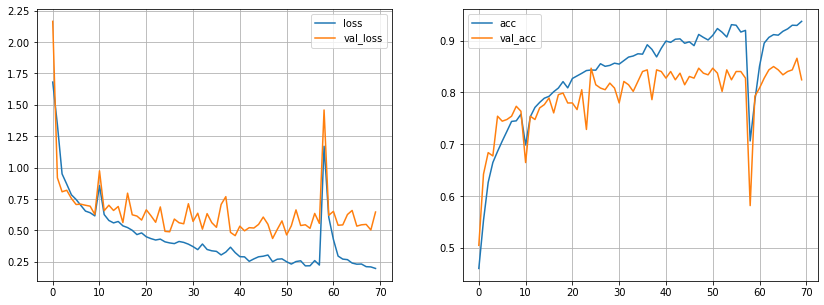

In [ ]:
show_history(history)

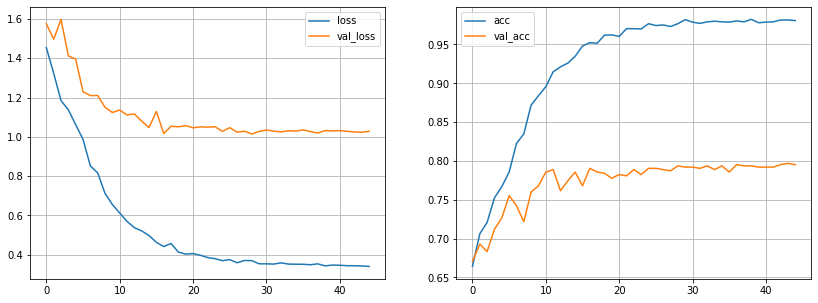

In [ ]:
# submission3
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.90
show_history(history)

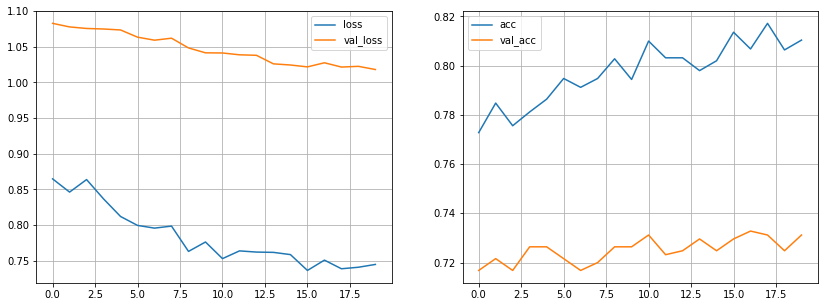

In [ ]:
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.90 # vgg lstm 2
show_history(history, 30)

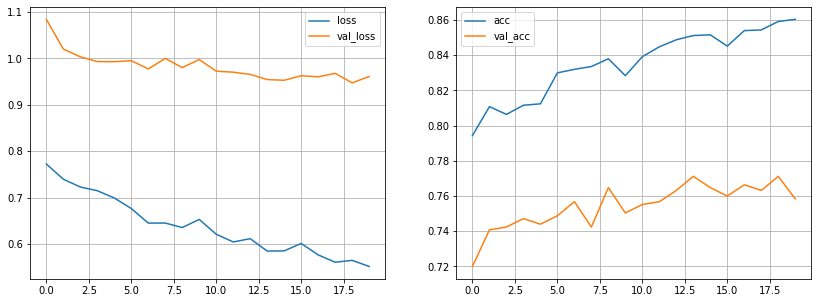

In [ ]:
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.92 # vgg lstm 2
show_history(history, 30)

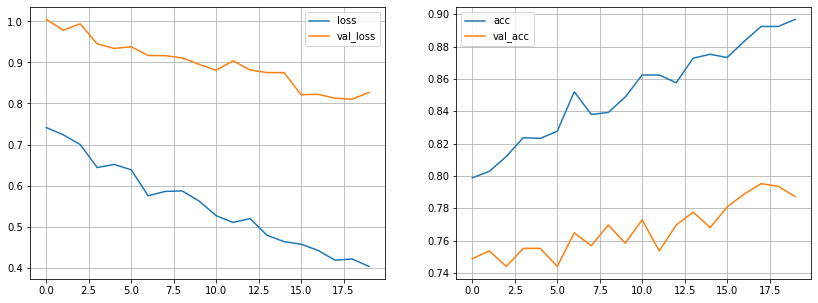

In [ ]:
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.95 # vgg lstm 2
show_history(history, 30)

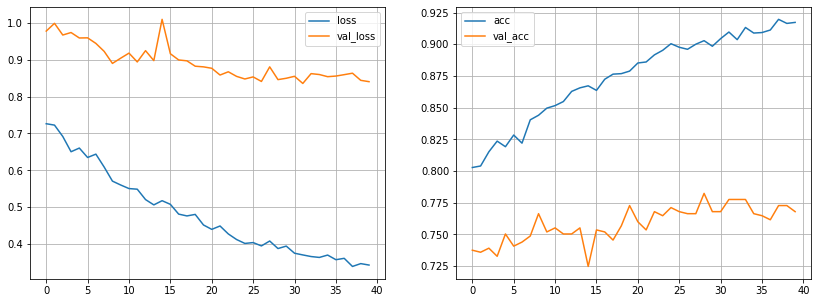

In [ ]:
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.95 # vgg lstm 2 # epoch70
show_history(history, 30)

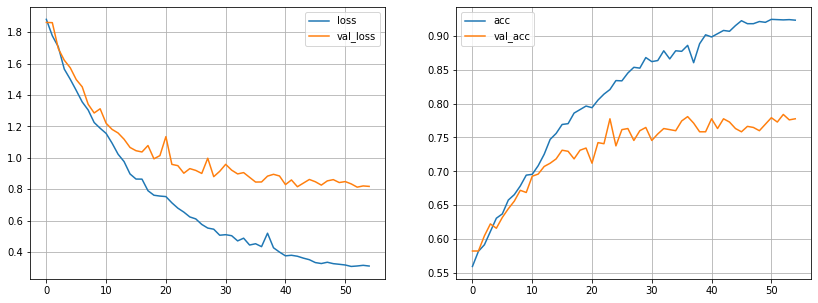

In [ ]:
# submission4 X
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.95 # vgg3 lstm 2 # epoch60 # res3
show_history(history, 5)

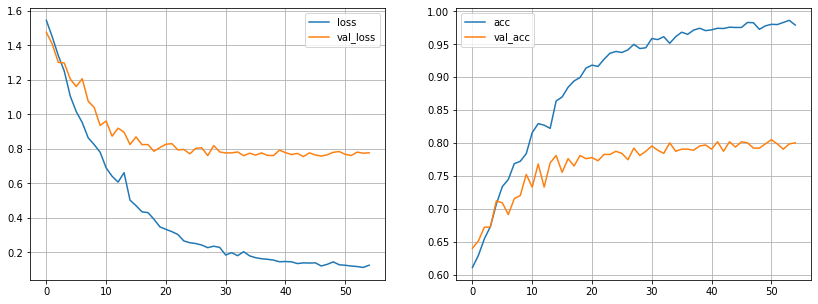

In [ ]:
# submission 5 ? X
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.94 # vgg 4block lstm 2 # epoch60 # res
show_history(history, 5)

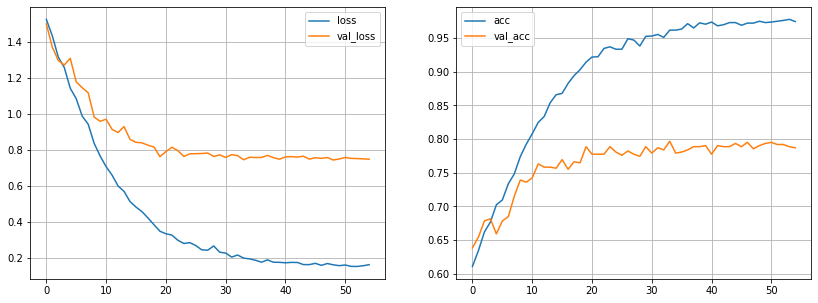

In [ ]:
# 
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.92 # vgg 4block lstm 2 # epoch60 # res
show_history(history, 5)

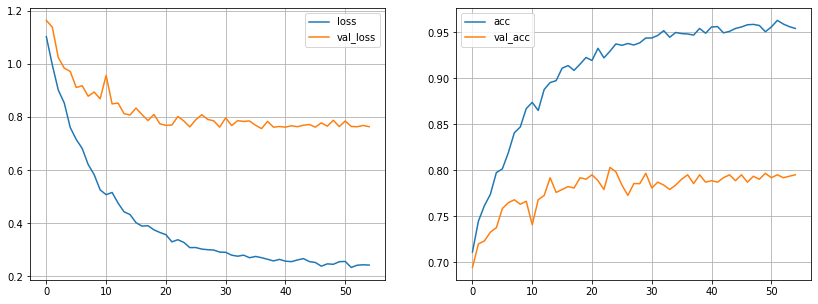

In [ ]:
# 
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.93 # vgg 4block avg # epoch60 # res
show_history(history, 5)

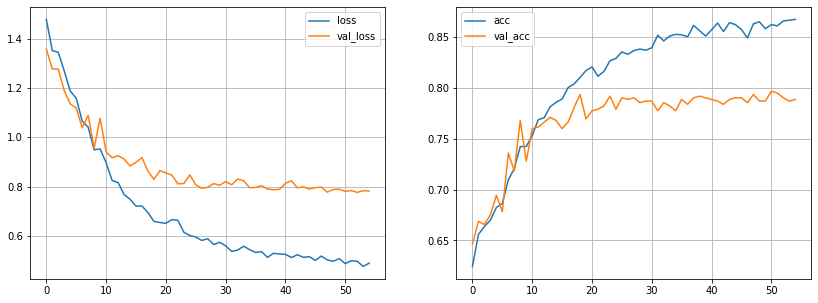

In [ ]:
# 
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.93 # vgg 4block avg # epoch60 # res # dropout
show_history(history, 5)

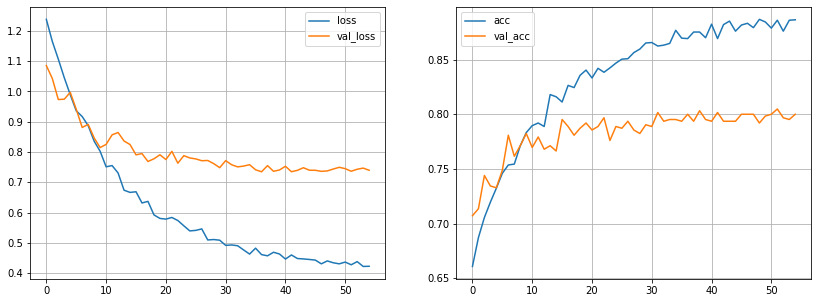

In [ ]:
# 
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.93 # vgg 4block avg # epoch60 # res # dropout # elu
show_history(history, 5)

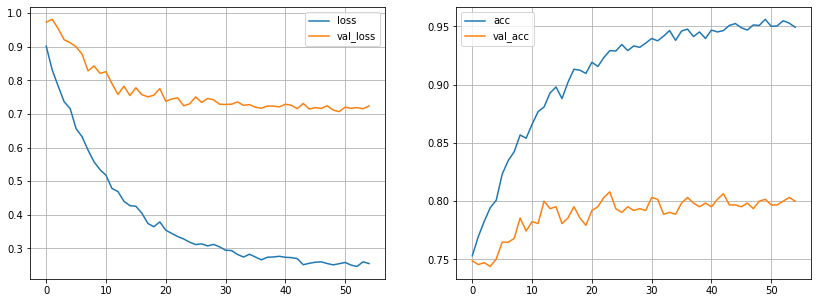

In [ ]:
# submission 4 # 0.658
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.93 # vgg 4block avg # epoch60 # res # elu # batchsize 16
show_history(history, 5)

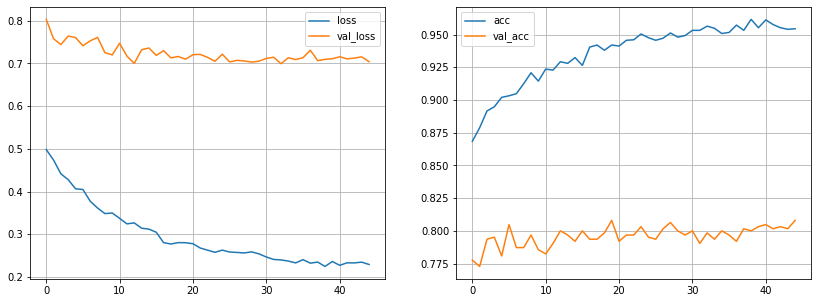

In [ ]:
# submission 5 # 0.673 # sub6 x
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.93 # vgg 4block avg # epoch60 # res # elu # batchsize 12
show_history(history, 15)

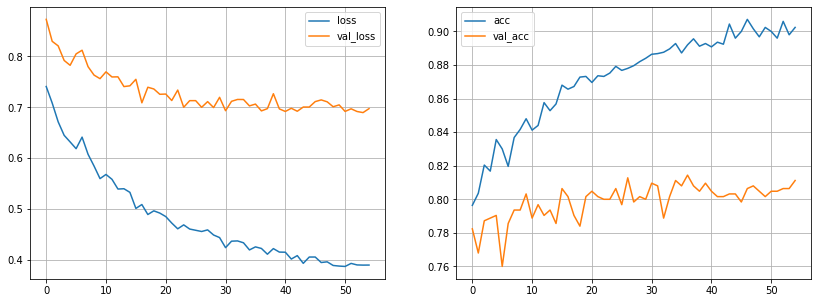

In [ ]:
# sub7? 
# optimizer = SGD(lr=0.001, momentum=0.9) # validation=0.2 # lr * 0.95 # epoch70 # vggres # elu # batchsize 12
show_history(history, 15)

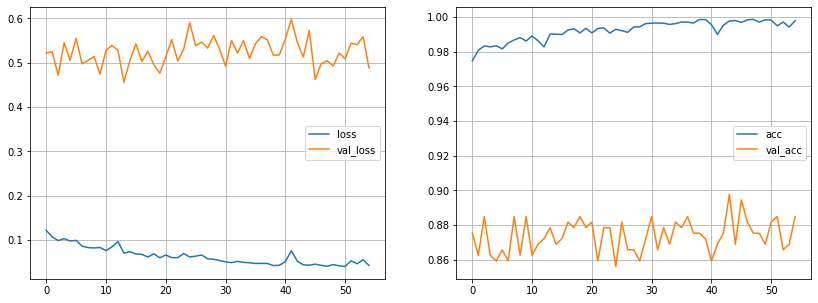

In [ ]:
# 
show_history(history, 15)

In [ ]:
# 
show_history(history, 15)

NameError: ignored

## test 처리

In [ ]:
df = pd.read_csv('./data/test_features.csv')
# df

In [ ]:
test = df.values[:,2:].reshape(-1,600,6)
test.shape

(782, 600, 6)

In [ ]:
test[:,:,3:] /= 100

acc_std = np.std(test[:,:,:3], axis=-1).reshape(-1, 600, 1)
gy_std = np.std(test[:,:,3:], axis=-1).reshape(-1, 600, 1)

# acc_mean = np.mean(test[:,:,:3], axis=-1).reshape(-1, 600, 1)
# gy_mean = np.mean(test[:,:,3:], axis=-1).reshape(-1, 600, 1)

# acc_norm = np.linalg.norm(test[:,:,:3], axis=-1).reshape(-1, 600, 1)
# gy_norm = np.linalg.norm(test[:,:,3:], axis=-1).reshape(-1, 600, 1)

# std = np.std(test[:,:,:], axis=-1).reshape(-1, 600, 1)

test = np.concatenate([test, acc_std, gy_std], axis=-1)
# test = np.concatenate([test, acc_std, gy_std, acc_mean, gy_mean, acc_norm, gy_norm], axis=-1)
test.shape


(782, 600, 8)

## 예측 및 submission

In [ ]:
df = pd.read_csv('./data/sample_submission.csv')
# df

In [ ]:
yhat = model.predict(test)
df.iloc[:,1:] = yhat
df.to_csv('submission22.csv', index=False)
df

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,1.688795e-06,5.123937e-07,2.434599e-06,1.835744e-05,7.954415e-05,2.269528e-07,2.723124e-06,5.647609e-07,9.888729e-09,4.384841e-03,2.325315e-01,3.595214e-01,3.981870e-05,3.776880e-01,6.155451e-04,1.251354e-06,6.388536e-07,2.632228e-06,1.083588e-07,6.798213e-07,5.484081e-05,6.063795e-06,2.199098e-07,1.230492e-03,4.625281e-03,5.929278e-06,0.000033,3.782607e-07,9.720724e-07,9.747743e-08,3.871012e-05,1.096387e-03,1.614702e-05,4.277946e-06,4.075617e-07,2.958942e-07,6.017257e-04,8.163087e-05,7.990088e-05,3.770809e-06,5.347250e-06,2.097947e-06,5.891980e-04,1.091181e-05,8.103153e-07,5.085931e-06,5.508680e-05,5.284985e-07,4.457856e-06,3.324812e-06,1.509095e-07,3.039622e-03,4.339076e-05,2.879827e-05,5.837295e-07,6.735782e-07,1.214997e-07,1.262367e-09,1.343586e-02,8.113754e-07,3.445571e-07
1,3126,1.679354e-03,4.056937e-04,4.074386e-05,1.287896e-03,4.684106e-05,6.422677e-04,4.607105e-06,8.422859e-04,1.275221e-06,3.473450e-05,3.794270e-05,5.432681e-06,1.345472e-06,3.953107e-05,3.558179e-05,3.439676e-04,3.423315e-04,2.873893e-05,1.124651e-05,1.268299e-05,3.330470e-05,1.633649e-04,2.096913e-03,6.632744e-04,2.825613e-04,3.407763e-04,0.972975,2.683823e-04,2.845237e-07,5.956140e-07,6.216333e-06,4.934318e-06,5.001922e-03,6.915711e-05,1.152127e-04,4.691196e-04,6.448306e-06,2.404028e-05,5.859615e-06,1.790250e-07,2.250745e-03,5.236717e-05,5.330564e-05,1.220588e-05,2.838869e-04,2.188770e-04,1.392866e-05,1.584146e-04,9.359361e-04,1.124187e-04,1.374458e-03,8.004138e-07,3.168397e-07,1.813237e-05,1.378215e-04,1.618232e-04,3.243476e-04,4.090601e-03,1.243864e-04,1.203261e-04,1.182809e-03
2,3127,1.428312e-05,6.276116e-04,1.743970e-07,2.721821e-07,4.490225e-07,7.527555e-07,5.550860e-04,6.034398e-05,3.509163e-08,7.483937e-08,2.451503e-05,3.396302e-07,3.830292e-06,1.588491e-06,3.121549e-04,2.523582e-07,1.614577e-05,5.536316e-08,4.832545e-08,3.371250e-07,3.992788e-08,4.595558e-06,1.016876e-06,3.995007e-07,1.889796e-04,6.994976e-06,0.000042,1.415475e-06,2.606742e-06,3.897209e-06,7.890544e-08,1.169269e-05,3.397589e-06,2.237540e-04,3.805430e-05,3.058587e-08,2.073993e-04,3.529809e-04,9.537739e-06,1.712247e-06,1.414432e-05,1.010967e-07,6.085948e-06,1.489192e-05,3.681539e-03,9.902205e-01,2.049016e-06,7.599716e-04,2.247686e-03,1.821008e-05,1.594247e-07,4.598977e-08,9.471971e-07,1.348796e-08,1.790311e-05,1.008171e-07,3.938710e-06,1.433279e-05,4.532557e-05,3.995350e-05,1.934908e-04
3,3128,7.411390e-05,6.487031e-07,2.304274e-04,3.593696e-05,8.208258e-08,2.341844e-05,3.591102e-07,7.486784e-05,7.247882e-04,6.585521e-06,8.382090e-05,2.723237e-05,2.994040e-06,3.415949e-05,1.076037e-05,1.787468e-04,4.803519e-07,3.837392e-07,2.056930e-07,4.080450e-06,1.357377e-05,1.147561e-04,1.329514e-04,1.927880e-04,7.342183e-06,9.417396e-06,0.985378,6.940595e-06,5.964660e-05,8.246143e-07,5.609326e-07,3.651754e-07,1.630404e-03,4.099660e-06,5.250643e-07,3.492907e-04,1.236677e-05,4.866745e-06,1.101215e-05,3.994227e-07,8.544799e-06,2.428606e-05,4.410756e-06,3.269474e-05,1.800638e-05,6.059511e-06,3.510614e-06,1.583852e-06,1.040721e-03,5.490893e-03,3.260438e-03,5.641768e-05,4.831275e-06,4.296626e-05,3.332722e-05,1.463439e-04,1.690209e-06,1.907277e-06,6.070426e-06,5.173875e-07,3.707491e-04
4,3129,1.113134e-05,2.839353e-08,7.168908e-10,1.228019e-06,8.987990e-07,1.111743e-06,1.019137e-08,6.138905e-09,1.442412e-09,3.735593e-08,3.577185e-10,8.219774e-10,2.049338e-09,7.701083e-10,2.951311e-09,1.060129e-04,1.142117e-07,6.315683e-08,1.296753e-05,4.964750e-08,1.252279e-09,9.372610e-09,6.386064e-07,3.681838e-09,1.732007e-07,4.831562e-08,0.999603,5.642362e-10,1.741707e-09,6.471312e-09,5.005368e-08,1.562263e-09,7.767264e-05,1.071279e-07,1.056314e-05,7.817727e-08,6.337815e-08,4.021991e-10,2.665246e-08,3.332232e-09,2.963342e-09,1.388479e-07,2.395878e-08,2.244345e-08,3.344444e-10,5.579766e-10,5.469668e-08,2.135910e-09,4.213725e-06

In [ ]:
# best keep
yhat = model.predict(test)
df.iloc[:,1:] = yhat
df.to_csv('submission14.csv', index=False)
df

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000152,3.411008e-06,7.245286e-05,9.385428e-04,6.661430e-05,1.196903e-05,7.979254e-05,1.801511e-06,1.951556e-06,1.470032e-01,1.798652e-01,1.959148e-01,1.214148e-03,3.063737e-01,3.020517e-04,0.000307,1.075014e-05,1.627134e-06,1.891004e-06,7.944158e-07,4.878543e-06,2.327982e-05,3.832361e-06,2.301199e-03,5.049993e-02,9.820116e-07,0.000107,1.375419e-05,5.375694e-06,2.484838e-05,9.648689e-04,1.227287e-02,0.000052,1.794296e-05,2.164966e-04,3.739344e-05,1.840860e-03,5.756099e-05,2.194306e-04,1.901993e-04,5.115176e-06,3.517014e-06,1.780971e-05,7.079298e-07,4.156136e-07,1.633762e-05,4.367107e-05,6.224714e-06,0.000024,0.000116,4.290821e-06,5.260447e-03,1.352501e-03,9.237123e-04,1.513296e-04,7.102646e-06,4.559487e-06,3.443195e-06,9.086101e-02,8.434930e-06,1.087591e-05
1,3126,0.000727,1.017457e-04,1.291996e-04,8.452434e-04,2.642057e-05,8.481754e-04,5.163692e-06,6.286416e-04,1.239989e-05,1.005642e-05,4.976743e-05,8.734576e-06,2.064851e-06,5.969284e-05,1.341532e-05,0.000532,2.404840e-05,1.111488e-05,2.384454e-05,1.365241e-05,7.062028e-05,9.189431e-04,3.854254e-03,1.390490e-03,7.300430e-05,9.389368e-04,0.968214,1.017241e-03,1.641972e-06,2.933215e-06,6.520145e-06,5.930221e-06,0.001136,2.132025e-04,9.911121e-05,3.630745e-04,1.808803e-04,1.149523e-05,3.187312e-05,5.831478e-07,2.709909e-03,1.456481e-04,1.715740e-04,2.926736e-05,1.728390e-04,1.217301e-04,1.986840e-05,1.212696e-04,0.000995,0.002470,3.613257e-03,3.575299e-05,1.189020e-06,1.147641e-04,4.828413e-04,4.762852e-04,1.108849e-03,3.928692e-03,1.393158e-05,9.928007e-05,5.647721e-04
2,3127,0.001451,4.443395e-03,2.255128e-06,1.601009e-05,2.506443e-06,1.980139e-05,2.474568e-02,3.228433e-04,7.782422e-06,3.396543e-05,1.628350e-04,5.005211e-06,3.326694e-06,3.666425e-05,1.117119e-03,0.000219,1.876420e-05,6.155796e-07,4.516696e-07,4.841322e-06,1.214916e-06,1.986470e-05,1.444156e-06,1.147264e-05,6.901190e-05,2.862908e-05,0.000685,1.538306e-04,4.047544e-05,1.086915e-04,3.328277e-06,1.125600e-05,0.000329,1.702884e-04,3.962818e-04,1.467303e-06,5.417478e-05,9.772304e-03,7.153308e-04,3.977178e-06,4.047416e-05,1.856698e-06,7.802652e-04,9.398368e-04,1.142779e-02,9.100750e-01,1.982153e-06,2.086656e-02,0.005648,0.000092,7.218179e-06,6.433166e-06,2.588234e-06,4.547203e-06,2.928394e-03,1.081658e-06,2.172048e-06,1.760583e-05,2.063334e-05,1.138149e-04,1.831773e-03
3,3128,0.000241,1.626715e-05,2.955929e-04,7.847835e-05,1.121675e-05,1.403333e-04,2.718804e-06,6.499863e-05,1.596115e-03,8.950593e-05,1.555139e-04,2.459873e-04,1.241683e-05,2.677231e-05,3.056132e-05,0.001245,1.736729e-05,4.268753e-06,1.876764e-05,7.326775e-06,3.935935e-05,5.543084e-05,6.154053e-04,1.260113e-04,4.634724e-04,5.205071e-05,0.974465,2.847556e-05,6.377872e-05,7.932388e-05,1.137283e-05,1.547258e-05,0.002764,3.932637e-05,1.238836e-05,1.059229e-04,5.656228e-05,1.646111e-05,3.381830e-05,8.237212e-06,2.578857e-04,1.055521e-04,3.688321e-04,1.212101e-04,4.389965e-05,4.168387e-05,1.475341e-05,3.351473e-05,0.001827,0.011003,6.899351e-04,3.343479e-04,1.963289e-05,8.575533e-05,3.216166e-05,1.638989e-04,1.027414e-04,2.917054e-04,5.949720e-05,2.056872e-05,1.030244e-03
4,3129,0.000034,2.042070e-06,7.164837e-08,2.470075e-06,3.603330e-05,1.641100e-06,2.253278e-08,9.963474e-08,1.166131e-07,2.164572e-07,3.177708e-07,6.414230e-08,1.045569e-08,9.223639e-08,4.428784e-08,0.000019,1.386688e-06,2.187551e-06,9.687101e-06,3.255654e-07,3.310919e-08,2.020354e-07,9.072988e-06,1.643361e-06,2.550006e-06,4.119645e-06,0.999135,4.548639e-08,1.699657e-08,1.878442e-07,1.513626e-06,5.591212e-07,0.000011,8.501000e-06,7.611594e-05,1.252174e-06,4.081247e-07,2.014208e-08,6.662386e-07,3.950004e-08,4.540887e-07,8.222383e-07,1.375377e-06,3.536949e-07,1.416841e-07,8.376510e-08,8.908823e-07,1.319181e-07,0.000010,0.000081,4.327870e-04,1.104613e-08,1.819047e-08,7.053110e-08,2.175860e-08,2.938766e-08,4.387300

In [ ]:
model2 = Model(model_input, model.layers[-2].output)
new_train_x = model2.predict(train_x)
new_test = model2.predict(test)

In [ ]:
yhat = xgbr.predict(new_test)
df.iloc[:,1:] = yhat
df.to_csv('submission8.csv', index=False)
df

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000525,0.000290,0.000292,0.001272,0.000706,0.000292,0.000291,0.000291,0.000324,0.009737,0.028785,0.329519,0.012786,0.586933,0.000413,0.000329,0.000389,0.000323,0.000286,0.000376,0.000326,0.000312,0.000326,0.000464,0.001137,0.000284,0.000423,0.000295,0.000296,0.000283,0.000988,0.002477,0.000402,0.000329,0.000636,0.000387,0.002122,0.000371,0.000860,0.000479,0.000299,0.000289,0.000384,0.000390,0.000347,0.000290,0.000335,0.000286,0.000407,0.000689,0.000307,0.002099,0.001506,0.000483,0.000404,0.000278,0.000283,0.000328,0.002622,0.000323,0.000296
1,3126,0.000110,0.000089,0.000091,0.000095,0.000085,0.000147,0.000099,0.000120,0.000089,0.000091,0.000088,0.000091,0.000083,0.000088,0.000086,0.000313,0.000120,0.000099,0.000088,0.000115,0.000099,0.000090,0.000390,0.000120,0.000091,0.000142,0.993264,0.000091,0.000086,0.000087,0.000108,0.000090,0.000170,0.000102,0.000093,0.000127,0.000114,0.000114,0.000100,0.000102,0.000108,0.000089,0.000093,0.000092,0.000100,0.000087,0.000103,0.000088,0.000116,0.000217,0.000161,0.000092,0.000085,0.000096,0.000094,0.000085,0.000096,0.000163,0.000088,0.000099,0.000082
2,3127,0.001297,0.002881,0.000503,0.000627,0.000479,0.000747,0.002471,0.001007,0.002274,0.000995,0.000585,0.000770,0.000478,0.000498,0.000612,0.000600,0.000664,0.000549,0.000489,0.000636,0.000547,0.000508,0.000520,0.000523,0.000520,0.000633,0.010408,0.000724,0.000618,0.000481,0.000683,0.000498,0.001278,0.000942,0.001669,0.000506,0.001127,0.001170,0.000949,0.000578,0.000974,0.000499,0.000513,0.000831,0.005259,0.921667,0.000570,0.001349,0.007992,0.001243,0.000676,0.000520,0.000501,0.000532,0.003034,0.000472,0.000865,0.000559,0.000548,0.001374,0.005980
3,3128,0.000141,0.000092,0.000093,0.000092,0.000088,0.000111,0.000092,0.000123,0.000099,0.000092,0.000091,0.000091,0.000086,0.000091,0.000089,0.000099,0.000124,0.000103,0.000091,0.000163,0.000103,0.000101,0.000118,0.000139,0.000111,0.000091,0.992884,0.000094,0.000089,0.000091,0.000112,0.000094,0.000860,0.000094,0.000097,0.000095,0.000096,0.000099,0.000104,0.000105,0.000096,0.000092,0.000109,0.000106,0.000104,0.000090,0.000107,0.000091,0.000139,0.000323,0.000126,0.000098,0.000099,0.000103,0.000097,0.000094,0.000090,0.000091,0.000094,0.000103,0.000122
4,3129,0.000043,0.000022,0.000020,0.000029,0.000065,0.000021,0.000019,0.000020,0.000019,0.000022,0.000019,0.000022,0.000020,0.000020,0.000020,0.000075,0.000026,0.000022,0.000021,0.000025,0.000022,0.000020,0.000055,0.000029,0.000020,0.000023,0.998215,0.000020,0.000019,0.000019,0.000024,0.000020,0.000086,0.000025,0.000036,0.000020,0.000020,0.000021,0.000022,0.000022,0.000020,0.000019,0.000026,0.000025,0.000022,0.000019,0.000022,0.000019,0.000132,0.000112,0.000056,0.000019,0.000019,0.000021,0.000020,0.000019,0.000019,0.000052,0.000019,0.000022,0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.000253,0.000080,0.000077,0.000120,0.000971,0.000084,0.000076,0.000156,0.000113,0.000077,0.000127,0.000086,0.000088,0.000128,0.000105,0.002014,0.000103,0.000131,0.000221,0.000099,0.000086,0.000084,0.000206,0.000078,0.000263,0.000127,0.988624,0.000078,0.000074,0.000088,0.000079,0.000077,0.000212,0.000160,0.001287,0.000079,0.000090,0.000080,0.000112,0.000087,0.000086,0.000089,0.000095,0.000097,0.000096,0.000076,0.000088,0.000075,0.000406,0.000225,0.000225,0.000076,0.000080,0.000082,0.000080,0.000073,0.000134,0.000258,0.000105,0.000085,0.000389
778,3903,0.000056,0.000029,0.000028,0.000093,0.000030,0.000031,0.000027,0.000128,0.000040,0.000028,0.000027,0.000031,0.000026,0.000028,0.000027,0.000123,0.000037,0.000031,0.000045,0.000036,0.000031,0.000029,0.000075,0.000053,0.000028

In [ ]:
from xgboost import XGBRegressor
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# x_train, x_valid, y_train, y_valid = train_test_split(train_x.reshape(-1,600*6), train_y, test_size=0.2, random_state=42)
# x_train, x_valid, y_train, y_valid = train_test_split(new_train_x, train_y, test_size=0.2, random_state=42)

param = {'objective':'multi:softprob'}
xgbr = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, tree_method='gpu_hist', gpu_id=0, num_class=61, **param)
# xgbr.fit(x_train, y_train, early_stopping_rounds=20, eval_metric='mlogloss', eval_set=[(x_train, y_train),(x_valid, y_valid)])
xgbr.fit(new_train_x, train_y, early_stopping_rounds=20, eval_metric='mlogloss', eval_set=[(new_train_x, train_y)])

[0]	validation_0-mlogloss:3.94924
Will train until validation_0-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:3.81403
[2]	validation_0-mlogloss:3.69786
[3]	validation_0-mlogloss:3.59441
[4]	validation_0-mlogloss:3.50046
[5]	validation_0-mlogloss:3.41391
[6]	validation_0-mlogloss:3.33507
[7]	validation_0-mlogloss:3.26168
[8]	validation_0-mlogloss:3.19204
[9]	validation_0-mlogloss:3.12619
[10]	validation_0-mlogloss:3.06409
[11]	validation_0-mlogloss:3.0049
[12]	validation_0-mlogloss:2.94848
[13]	validation_0-mlogloss:2.89479
[14]	validation_0-mlogloss:2.84284
[15]	validation_0-mlogloss:2.79325
[16]	validation_0-mlogloss:2.74546
[17]	validation_0-mlogloss:2.69934
[18]	validation_0-mlogloss:2.65485
[19]	validation_0-mlogloss:2.61181
[20]	validation_0-mlogloss:2.57023
[21]	validation_0-mlogloss:2.52995
[22]	validation_0-mlogloss:2.49082
[23]	validation_0-mlogloss:2.45309
[24]	validation_0-mlogloss:2.41652
[25]	validation_0-mlogloss:2.38076
[26]	validation_0-mlogloss:2.346

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, num_class=61, objective='multi:softprob',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)